In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.errors import InvalidDicomError
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

2025-01-14 12:53:02.745160: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 12:53:02.773089: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 12:53:02.774077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-14 12:53:03.314962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the dataset
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/All_XWalk_Outcome_cleaned.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

In [3]:
# Define the correct base path
correct_base_path = "/mnt/disk_share/AIRM"

# Replace 'Q:\\' with the correct base path and standardize separators
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Replace backslashes with forward slashes

# Debugging: Print sample paths to verify
print(data['FilePath'].head())

0    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
1    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
2    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
3    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
4    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
Name: FilePath, dtype: object


In [4]:
print(data['ethnicity'].unique())

['BR' 'EA' 'OT' 'NE' 'SA' 'SE' 'FR' 'R' 'WE' 'EE' 'BL' 'AP']


In [5]:
# Map ethnicity to 5 classes
def map_ethnicity(ethnicity):
    mapping = {
        "BR": "White", "EE": "White", "FR": "White", "NE": "White", "SE": "White", "WE": "White",
        "EA": "Asian - East and Southeast",
        "SA": "Asian - South",
        "AP": "Aboriginal",
        "BL": "Black"
    }
    return mapping.get(ethnicity, "Other")

data['ethnicity'] = data['ethnicity'].apply(map_ethnicity)

In [ ]:
# Filter out "Other" ethnicity
filtered_data = data[data['ethnicity'] != "Other"]

# Check data
# print(filtered_data.head())

        patient_id               PatientName  PatientDOB OriginalID  \
0  20130102_0g0aud  Roberge^Annette^Patricia  1958-09-17    9093889   
1  20130102_1s02ke             Kim^Myung Soo  1949-12-26    2191507   
2  20130102_4gw29z          Cunnington^Donna  1939-05-18    1093886   
3  20130102_5fjuf1          Lo^Anita^Oi Fong  1951-09-13    2186762   
4  20130102_5ih7tj               Meng^Jinsoo  1952-10-08    2191501   

   StudyDate AccessionNumber  \
0   20130102    104MG1300015   
1   20130102    104MG1300048   
2   20130102    104MG1300018   
3   20130102    104MG1300058   
4   20130102    104MG1300019   

                                            FilePath      SheetName  \
0  /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...  BCW-Screening   
1  /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...  BCW-Screening   
2  /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...  BCW-Screening   
3  /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...  BCW-Screening   
4  /mnt/disk_share/AIRM/B

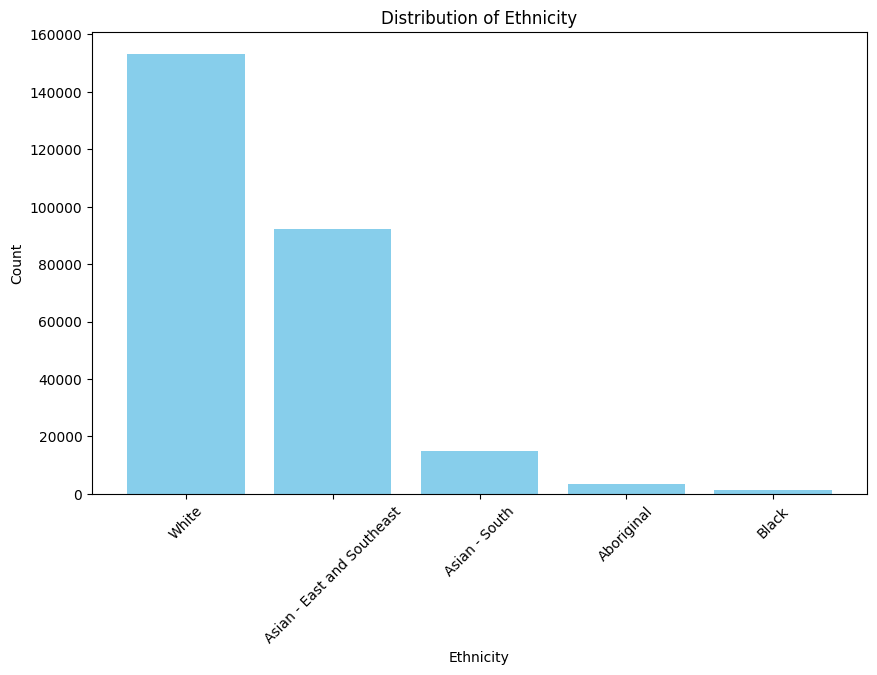

In [19]:
# Show the distribution of ethnicity
ethnicity_counts = filtered_data['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
# plt.style.use('default')
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

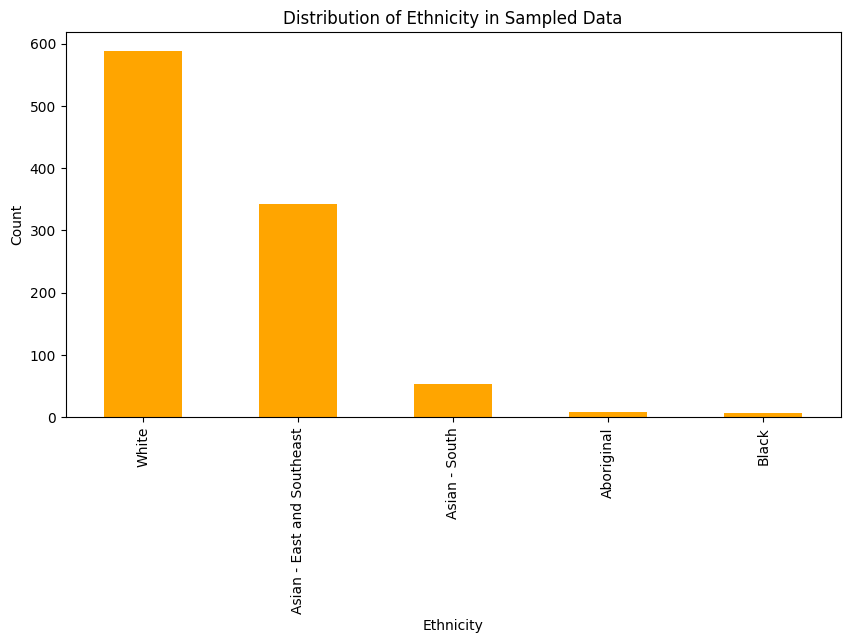

In [20]:
# Randomly select about 1000 images
data_sample = filtered_data.sample(n=1000, random_state=42)
# Verify sampled distribution
plt.figure(figsize=(10, 5))
data_sample['ethnicity'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribution of Ethnicity in Sampled Data')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.show()

In [10]:
# Filter out rows with invalid or missing FilePath
data_sample = data_sample.dropna(subset=['FilePath'])  # Remove rows with NaN in FilePath
data_sample = data_sample[data_sample['FilePath'].apply(lambda x: isinstance(x, str))]  # Keep only string paths

valid_filepaths = []
labels = []

for _, row in data_sample.iterrows():
    folder_path = row['FilePath']
    if os.path.exists(folder_path):  # Check if folder exists
        dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
        if dicom_files:  # Check if DICOM files are present
            valid_filepaths.append(os.path.join(folder_path, dicom_files[0]))
            labels.append(row['ethnicity'])

# Display count of valid files
print(f"Number of valid DICOM files: {len(valid_filepaths)}")

Number of valid DICOM files: 995


In [11]:
# Convert labels to numeric format
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_labels, label_mapping = encode_labels(labels)

# Prepare dataset for training
train_paths, test_paths, train_labels, test_labels = train_test_split(
    valid_filepaths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)

In [12]:
# Define example mapping
def map_example(filepath, label):
    try:
        dicom = dcmread(filepath.numpy().decode('utf-8'))
        if 'PixelData' not in dicom or dicom.pixel_array is None:
            raise ValueError("Invalid DICOM: Missing pixel data")
        image = dicom.pixel_array
        if len(image.shape) == 2:  # Grayscale image
            image = tf.expand_dims(image, axis=-1)  # Add channel dimension
        image = tf.image.resize(image, [224, 224])  # Resize to 224x224
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        return image, label
    except (InvalidDicomError, ValueError) as e:
        print(f"Skipping file {filepath.numpy().decode('utf-8')}: {e}")
        return tf.zeros((224, 224, 1)), -1  # Return dummy image and invalid label

# Wrapper function for TensorFlow compatibility
def tf_map_example(filepath, label):
    image, label = tf.py_function(func=map_example, inp=[filepath, label], Tout=(tf.float32, tf.int32))
    image.set_shape((224, 224, 1))  # Explicitly set shape for TensorFlow graph
    label.set_shape([])  # Set shape for label as scalar
    return image, label

# Create datasets
def make_dataset(filepaths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(tf_map_example)  # Use the wrapper function
    dataset = dataset.filter(lambda x, y: y != -1)  # Filter out invalid entries
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare datasets
train_dataset = make_dataset(train_paths, train_labels)
test_dataset = make_dataset(test_paths, test_labels)

2025-01-14 12:59:34.801130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-14 12:59:34.801341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-14 12:59:34.852404: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

In [13]:
for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")

Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20170710/20190919_wtyyzq/20170710_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20160617/20201103_p3d4ya/20160617_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20160927/20220916_pevezg/20160927_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20190426/20190426_ay1iwi/20190426_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32,)


Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20170710/20190919_wtyyzq/20170710_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20160617/20201103_p3d4ya/20160617_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20160927/20220916_pevezg/20160927_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20190426/20190426_ay1iwi/20190426_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data


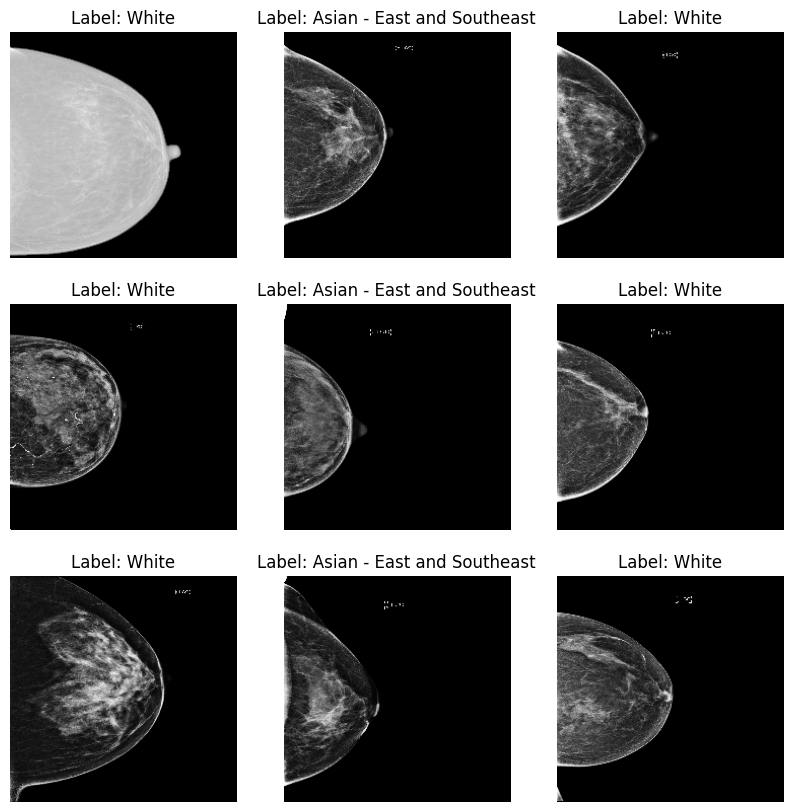

In [21]:
# Display sample images and their labels
for image_batch, label_batch in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(image_batch[i].numpy()), cmap="gray")
        plt.title(f"Label: {list(label_mapping.keys())[list(label_mapping.values()).index(label_batch[i].numpy())]}")
        plt.axis("off")
    plt.show()

In [15]:
# Build EfficientNetB0 model
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 1))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(label_mapping), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20170710/20190919_wtyyzq/20170710_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20160617/20201103_p3d4ya/20160617_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20160927/20220916_pevezg/20160927_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20190426/20190426_ay1iwi/20190426_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      4/Unknown - 283s 66s/step - loss: 1.2075 - accuracy: 0.4766Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20170422/20190618_pfv933/20170422_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      5/Unknown - 351s 6

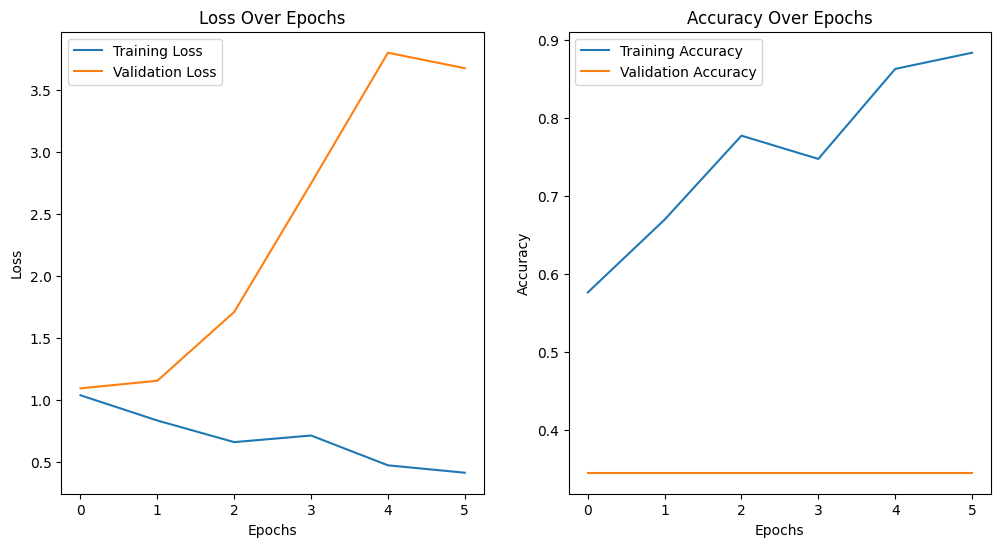

In [26]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

      1/Unknown - 49s 49s/stepSkipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20150317/20140327_n9fjff/20150317_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      2/Unknown - 94s 45s/stepSkipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20180201/20130814_u5s4i1/20180201_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20180328/20200603_9fp9h7/20180328_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      3/Unknown - 134s 43s/stepSkipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20130318/20130318_t55m3f/20130318_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      4/Unknown - 181s 44s/stepSkipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20161028/20191113_xfmhwj/20161028_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICO

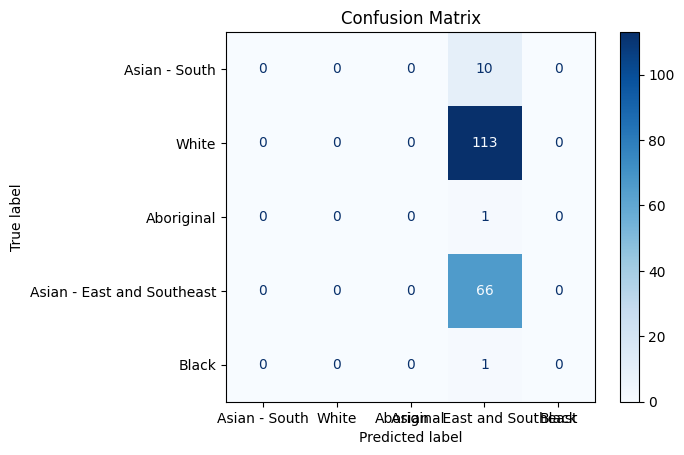

Classification Report:
                            precision    recall  f1-score   support

             Asian - South       0.00      0.00      0.00        10
                     White       0.00      0.00      0.00       113
                Aboriginal       0.00      0.00      0.00         1
Asian - East and Southeast       0.35      1.00      0.51        66
                     Black       0.00      0.00      0.00         1

                  accuracy                           0.35       191
                 macro avg       0.07      0.20      0.10       191
              weighted avg       0.12      0.35      0.18       191



/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [23]:
# Evaluate the model and compute metrics
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(label_mapping.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=list(label_mapping.keys())))
